In [44]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [45]:


# 경로 설정
base_path = 'D:/LabRoom/Projects/SD Physiology/Processed/processed_individual'
participant_list = sorted(list(set(f.split("_")[0] for f in os.listdir(base_path) if f.endswith("_Main.pkl"))))

# 파라미터 설정
fps = 120
window_seconds = 30
stride_seconds = 15
# window_seconds = 10
# stride_seconds = 5
window_size = window_seconds * fps
stride_size = stride_seconds * fps


# Step 1️⃣: 데이터 불러오기 및 Outside 필터링
data_dict = {}

for name in tqdm(participant_list, desc="Loading and Filtering"):
    file_path = os.path.join(base_path, f"{name}_Main.pkl")
    try:
        df = pd.read_pickle(file_path)
        df_outside = df[df['scene'] == 'Outside'].copy()
        if len(df_outside) >= window_size:
            data_dict[name] = df_outside
    except Exception as e:
        print(f"{name}: 오류 발생 - {e}")
        


Loading and Filtering: 100%|██████████| 108/108 [01:39<00:00,  1.08it/s]


In [46]:

# Step 0️⃣: 예시 participant로부터 column 구조만 추출
sample_name = participant_list[0]
sample_df = pd.read_pickle(os.path.join(base_path, f"{sample_name}_Main.pkl"))
sample_df = sample_df[sample_df['scene'] == 'Outside'].copy()
sample_df.reset_index(drop=True, inplace=True)

exclude_keywords = [
    'unit',       # face tracker
    'Frame',      # 단순 index
    'X_pos', 'Y_pos', 'Z_pos',     # 위치 좌표
    'X_rot', 'Y_rot', 'Z_rot',     # 회전값
    'validL', 'validR',            # 눈 추적 유효 여부 (bool성태 숫자)
    'gazeorigin', 'gazeL_', 'gazeR_',  # 시선 방향 좌표
    'pupilLSensorPos',             # 동공 센서 위치
     'eye_openness'
]
feature_cols = [
    col for col in sample_df.columns
    if (
        col not in ['anxiety', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        sample_df[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

Generating Windows: 100%|██████████| 108/108 [00:11<00:00,  9.21it/s]



✅ 최종 window 수: 2300
🚫 NaN 때문에 제외된 window 수: 56


,participant,start_idx,note
0,nsk9105,0,All NaN in anxiety
1,nsk9105,1800,All NaN in anxiety
2,nsk9105,3600,All NaN in anxiety
3,nsk9105,5400,All NaN in anxiety
4,nsk9105,7200,All NaN in anxiety


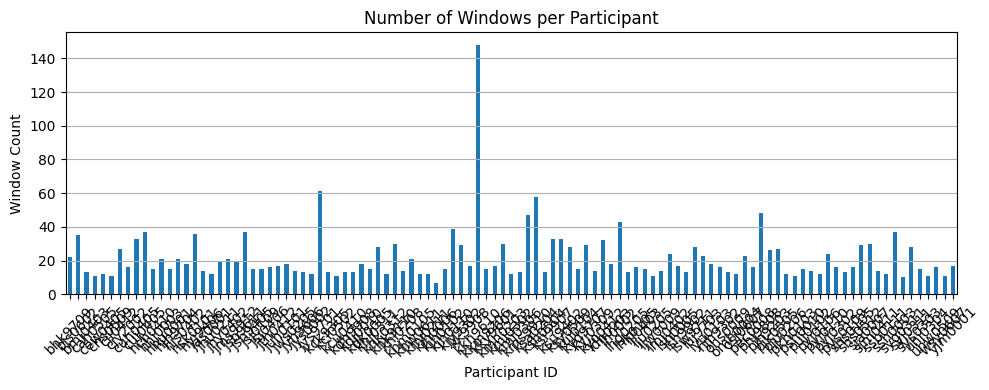

In [47]:
windowed_data = []
nan_log = []  # NaN 로그 저장
for name, df in tqdm(data_dict.items(), desc="Generating Windows"):
    df = df.reset_index(drop=True)
    for start in range(0, len(df) - window_size + 1, stride_size):
        end = start + window_size
        window_df = df.iloc[start:end]

        anxiety_values = window_df["anxiety"]
        anxiety_mean = anxiety_values.mean()

        # NaN인지 먼저 확인
        if np.isnan(anxiety_mean):
            nan_log.append({
                "participant": name,
                "start_idx": start,
                "note": "All NaN in anxiety"
            })
            continue  # 이 window는 skip

        features = {}
        for col in feature_cols:
            features[f"{col}_mean"] = window_df[col].mean()
            features[f"{col}_std"] = window_df[col].std()

        features["anxiety_mean"] = anxiety_mean
        features["participant"] = name
        features["start_idx"] = start
        windowed_data.append(features)

# 결과 저장
window_df_all = pd.DataFrame(windowed_data)
nan_log_df = pd.DataFrame(nan_log)

print(f"\n✅ 최종 window 수: {len(window_df_all)}")
print(f"🚫 NaN 때문에 제외된 window 수: {len(nan_log_df)}")

# 필요 시 확인
display(nan_log_df.head())


# Step 4️⃣: 참가자별 window 수 시각화
participant_counts = window_df_all['participant'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
participant_counts.plot(kind='bar')
plt.title("Number of Windows per Participant")
plt.xlabel("Participant ID")
plt.ylabel("Window Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [48]:
window_df_all = window_df_all[window_df_all["participant"] != "nsk9105"].reset_index(drop=True)

print(f"🚫 NaN 포함 참가자 'nsk9105' 제거 후 window 수: {len(window_df_all)}")

# 참가자별 window 개수 집계
participant_counts = window_df_all['participant'].value_counts()

# 5개 미만인 참가자만 추출
too_short = participant_counts[participant_counts < 5]

# 결과 출력
print(f"🚫 너무 짧은 참가자 수 (<5 windows): {len(too_short)}명")
display(too_short)

🚫 NaN 포함 참가자 'nsk9105' 제거 후 window 수: 2300
🚫 너무 짧은 참가자 수 (<5 windows): 0명


Series([], Name: count, dtype: int64)

In [49]:
window_df_all

,pupilL_mean,pupilL_std,pupilR_mean,pupilR_std,PPG_Raw_mean,PPG_Raw_std,PPG_Clean_mean,PPG_Clean_std,PPG_Rate_mean,PPG_Rate_std,...,RSP_Symmetry_PeakTrough_std,RSP_Symmetry_RiseDecay_mean,RSP_Symmetry_RiseDecay_std,RSP_Peaks_mean,RSP_Peaks_std,RSP_Troughs_mean,RSP_Troughs_std,anxiety_mean,participant,start_idx
0,3.535387,0.951745,3.514824,0.929619,0.028515,0.774338,-0.002428,0.663453,79.798493,7.149563,...,0.132534,0.482997,0.084984,0.000000,0.000000,0.000278,0.016667,3.837004,bhk9709,0
1,3.635164,1.143266,3.591151,1.133279,0.061006,0.600799,0.010035,0.469510,80.496823,7.591217,...,0.147103,0.494769,0.096081,0.000000,0.000000,0.000000,0.000000,3.888736,bhk9709,1800
2,3.538640,1.212003,3.447212,1.185647,0.044282,0.426336,0.001874,0.423910,82.334116,3.944406,...,0.147667,0.451113,0.125586,0.000556,0.023567,0.000278,0.016667,3.391622,bhk9709,3600
3,3.509464,1.221175,3.386575,1.171262,0.035735,0.556000,-0.001552,0.553919,81.448231,2.836463,...,0.113679,0.388130,0.068652,0.000556,0.023567,0.000278,0.016667,2.922267,bhk9709,5400
4,3.707704,1.212888,3.545053,1.146004,0.034675,0.603205,0.000501,0.600585,79.984884,3.037781,...,0.058198,0.457867,0.071195,0.000000,0.000000,0.000000,0.000000,2.614383,bhk9709,7200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,3.945354,1.633895,4.036067,1.512230,0.036283,0.169793,0.000799,0.160178,83.050174,3.867562,...,0.042122,0.374199,0.046282,0.000000,0.000000,0.000278,0.016667,4.295785,yjm0001,21600
2296,3.792688,1.604239,3.808079,1.357686,0.035994,0.352549,0.000110,0.278115,85.850665,4.288681,...,0.054489,0.430306,0.088282,0.000000,0.000000,0.000278,0.016667,4.723347,yjm0001,23400
2297,3.827599,1.465830,3.804627,1.213546,0.035050,0.353502,0.002825,0.282632,87.437784,5.182237,...,0.048376,0.458853,0.075266,0.000000,0.000000,0.000000,0.000000,4.965302,yjm0001,25200
2298,3.660895,1.195093,3.574408,1.157371,0.033237,0.320397,-0.003792,0.279069,80.102911,18.304017,...,0.071153,0.429933,0.067216,0.000000,0.000000,0.000000,0.000000,5.240357,yjm0001,27000


🚀 모델 학습 및 평가 시작


모델 진행 중:   0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
모델 진행 중:  14%|█▍        | 1/7 [00:00<00:01,  5.36it/s]

✅ LinearSVR 완료
✅ Ridge 완료


모델 진행 중:  43%|████▎     | 3/7 [00:06<00:09,  2.30s/it]

✅ RandomForest 완료


모델 진행 중:  57%|█████▋    | 4/7 [00:06<00:05,  1.67s/it]

✅ XGBoost 완료


모델 진행 중:  71%|███████▏  | 5/7 [00:10<00:04,  2.29s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10061
[LightGBM] [Info] Number of data points in the train set: 1555, number of used features: 58
[LightGBM] [Info] Start training from score 5.416951
✅ LightGBM 완료


모델 진행 중:  86%|████████▌ | 6/7 [00:10<00:01,  1.77s/it]

✅ CatBoost 완료


모델 진행 중: 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]

✅ MLP 완료


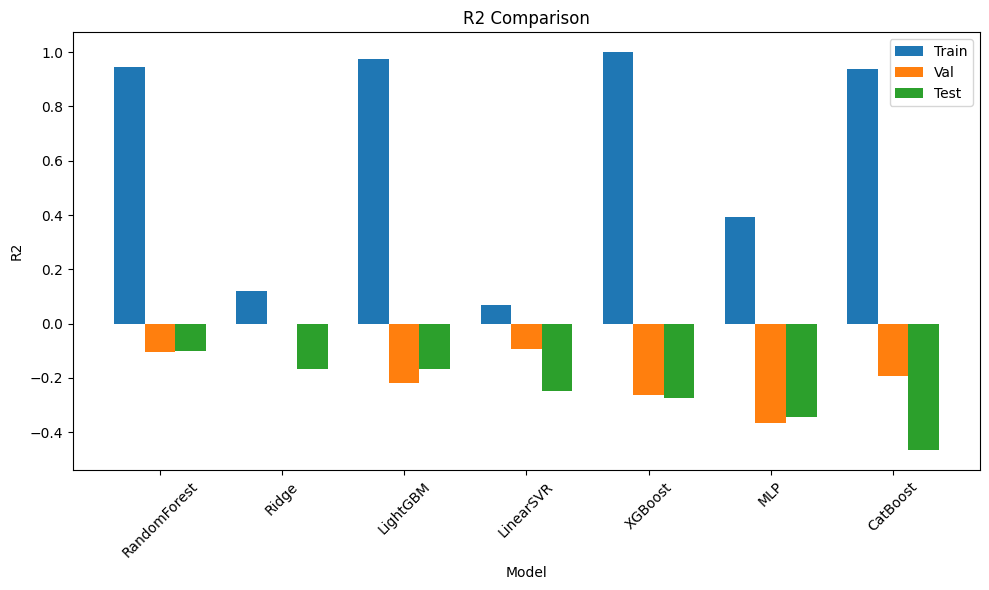

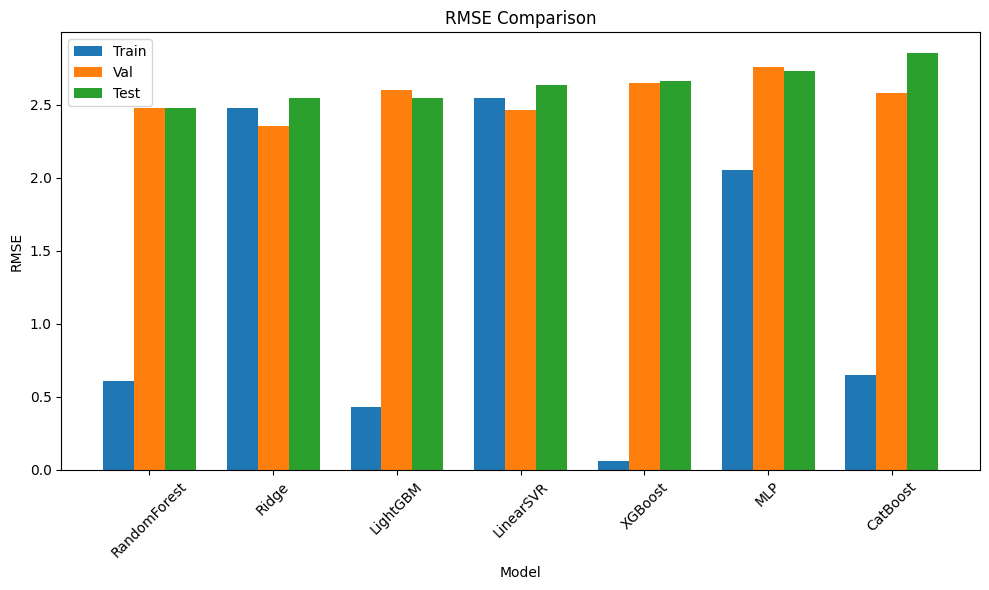

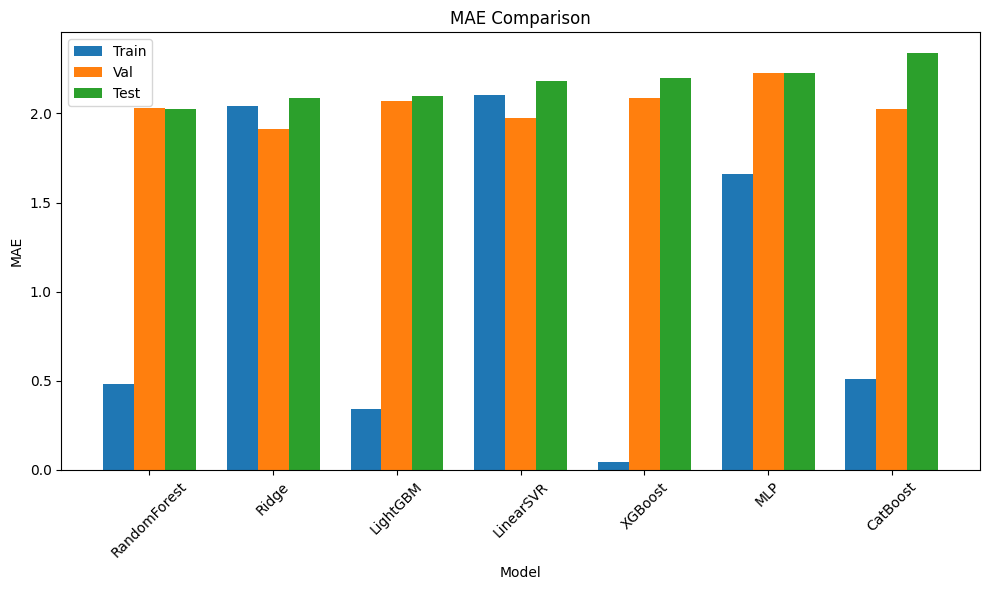

📋 전체 결과 요약:
          Model  R2_Train    R2_Val   R2_Test  RMSE_Train  RMSE_Val  \
2  RandomForest  0.946434 -0.103329 -0.102397    0.611310  2.477786   
1         Ridge  0.119717  0.000151 -0.167561    2.478151  2.358731   
4      LightGBM  0.973249 -0.219557 -0.168381    0.432000  2.605028   
0     LinearSVR  0.068398 -0.093614 -0.247923    2.549363  2.466853   
3       XGBoost  0.999440 -0.261765 -0.275271    0.062504  2.649723   
6           MLP  0.394304 -0.366877 -0.344457    2.055626  2.757884   
5      CatBoost  0.939225 -0.194460 -0.465449    0.651146  2.578083   

   RMSE_Test  MAE_Train   MAE_Val  MAE_Test  
2   2.475561   0.482107  2.027626  2.023181  
1   2.547677   2.043829  1.912461  2.083556  
4   2.548572   0.339361  2.067903  2.096881  
0   2.633896   2.102556  1.976860  2.184400  
3   2.662600   0.044139  2.088180  2.197970  
6   2.733872   1.658935  2.228330  2.227454  
5   2.854237   0.512542  2.022398  2.337756  

🧩 사용된 Feature 목록:
          Model                 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tqdm import tqdm  # ✅ 진행 시각화

# ✅ 데이터 준비
drop_cols = ['anxiety_mean', 'participant', 'start_idx']
X = window_df_all.drop(columns=drop_cols)
y = window_df_all['anxiety_mean'].values
participants = window_df_all['participant'].values

unique_pids = np.unique(participants)
train_pids, testval_pids = train_test_split(unique_pids, test_size=0.3, random_state=42)
val_pids, test_pids = train_test_split(testval_pids, test_size=0.5, random_state=42)

train_mask = np.isin(participants, train_pids)
val_mask = np.isin(participants, val_pids)
test_mask = np.isin(participants, test_pids)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

# ✅ 모델 정의
models = {
    'LinearSVR': LinearSVR(max_iter=1000, random_state=42),
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(n_estimators=100, random_state=42, verbose=0),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42, early_stopping=True)
}

# ✅ 결과 저장
results = []
feature_info = []

print("🚀 모델 학습 및 평가 시작")
for name, model in tqdm(models.items(), desc="모델 진행 중"):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    results.append({
        'Model': name,
        'R2_Train': r2_score(y_train, y_train_pred),
        'R2_Val': r2_score(y_val, y_val_pred),
        'R2_Test': r2_score(y_test, y_test_pred),
        'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE_Val': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE_Train': mean_absolute_error(y_train, y_train_pred),
        'MAE_Val': mean_absolute_error(y_val, y_val_pred),
        'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    })

    feature_info.append({
        'Model': name,
        'Features Used': list(X.columns)
    })

    print(f"✅ {name} 완료")

results_df = pd.DataFrame(results).sort_values(by='R2_Test', ascending=False)
feature_df = pd.DataFrame(feature_info)

# ✅ 시각화 (모델 완료 후 일괄)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
metrics = ['R2', 'RMSE', 'MAE']
sets = ['Train', 'Val', 'Test']

os.makedirs("figures", exist_ok=True)

for metric in metrics:
    plt.figure(figsize=(10, 6))
    bar_width = 0.25
    index = np.arange(len(results_df))
    for i, subset in enumerate(sets):
        plt.bar(index + i * bar_width,
                results_df[f'{metric}_{subset}'],
                width=bar_width,
                label=subset)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(index + bar_width, results_df['Model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/{metric}_comparison_{timestamp}.png')
    plt.show()

# ✅ 결과 출력
print("📋 전체 결과 요약:")
print(results_df)

print("\n🧩 사용된 Feature 목록:")
print(feature_df)


In [11]:
import pandas as pd

# 제외할 컬럼 정의
drop_cols = ['anxiety_mean', 'participant', 'start_idx']
feature_cols = [col for col in window_df_all.columns if col not in drop_cols]

# Z-score normalization 함수 정의
def zscore_normalize_by_participant(df, feature_cols, participant_col='participant'):
    df_normalized = df.copy()
    for pid in df[participant_col].unique():
        mask = df[participant_col] == pid
        subset = df.loc[mask, feature_cols]
        means = subset.mean()
        stds = subset.std()
        df_normalized.loc[mask, feature_cols] = (subset - means) / stds
    return df_normalized

# 정규화 적용
normalized_df = zscore_normalize_by_participant(window_df_all, feature_cols)

# NaN 비율 확인
nan_counts = normalized_df[feature_cols].isna().sum()
nan_ratio = nan_counts / len(normalized_df)

# 출력
print("📉 NaN 비율 상위 10개:")
print(nan_ratio.sort_values(ascending=False).head(10))


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_33520\1427255414.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.09145645 -0.84406934 -1.08339165 -1.15572953 -0.66421599  0.14481052
  0.27870759 -0.07366496 -0.41354633 -0.80840937 -1.55641107 -0.91282674
  0.80312348  1.14722788  1.18742715  1.21911886  1.38844476  1.45704669
  1.26983671  0.78959485 -0.19996895 -0.88163512]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_normalized.loc[mask, feature_cols] = (subset - means) / stds
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_33520\1427255414.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.14115796  0.72382529  0.93294465  0.96084969  0.93563603  0.21989687
 -0.72526818 -1.12434278 -1.97425512 -0.54185933  1.66230303  1.84776496
 -0.49278605 -1.30186084 -0.99385

📉 NaN 비율 상위 10개:
SCR_RecoveryTime_mean    0.471739
SCR_RecoveryTime_std     0.471739
SCR_Amplitude_std        0.460870
SCR_Amplitude_mean       0.460870
SCR_RiseTime_std         0.460870
SCR_RiseTime_mean        0.460870
SCR_Height_std           0.460870
SCR_Height_mean          0.460870
SCR_Peaks_mean           0.460870
SCR_Peaks_std            0.460870
dtype: float64


🚀 모델 학습 및 평가 시작


모델 진행 중:   0%|          | 0/7 [00:00<?, ?it/s]


⚙️  Feature selection for LinearSVR...


c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.p

✅ LinearSVR 완료 - 선택된 feature 수: 2

⚙️  Feature selection for Ridge...


모델 진행 중:  29%|██▊       | 2/7 [00:32<01:09, 13.86s/it]

✅ Ridge 완료 - 선택된 feature 수: 50

⚙️  Feature selection for RandomForest...
✅ RandomForest 완료 - 선택된 feature 수: 15


모델 진행 중:  43%|████▎     | 3/7 [1:16:21<2:18:58, 2084.64s/it]


⚙️  Feature selection for XGBoost...
✅ XGBoost 완료 - 선택된 feature 수: 21


모델 진행 중:  57%|█████▋    | 4/7 [1:18:47<1:05:58, 1319.57s/it]


⚙️  Feature selection for LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10133
[LightGBM] [Info] Number of data points in the train set: 5790, number of used features: 58
[LightGBM] [Info] Start training from score 5.235720
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10129
[LightGBM] [Info] Number of data points in the train set: 5790, number of used features: 57
[LightGBM] [Info] Start training from score 5.235720
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10125
[LightGBM] [Info] Number of data points in the train set: 5790, number of used f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
모델 진행 중:  71%|███████▏  | 5/7 [1:20:08<29:05, 872.69s/it]   


⚙️  Feature selection for CatBoost...
✅ CatBoost 완료 - 선택된 feature 수: 15


모델 진행 중:  86%|████████▌ | 6/7 [1:23:13<10:39, 639.09s/it]


⚙️  Feature selection for MLP...
⚠️  MLP - RFECV 불가능, SelectKBest 사용


모델 진행 중: 100%|██████████| 7/7 [1:23:14<00:00, 713.55s/it]


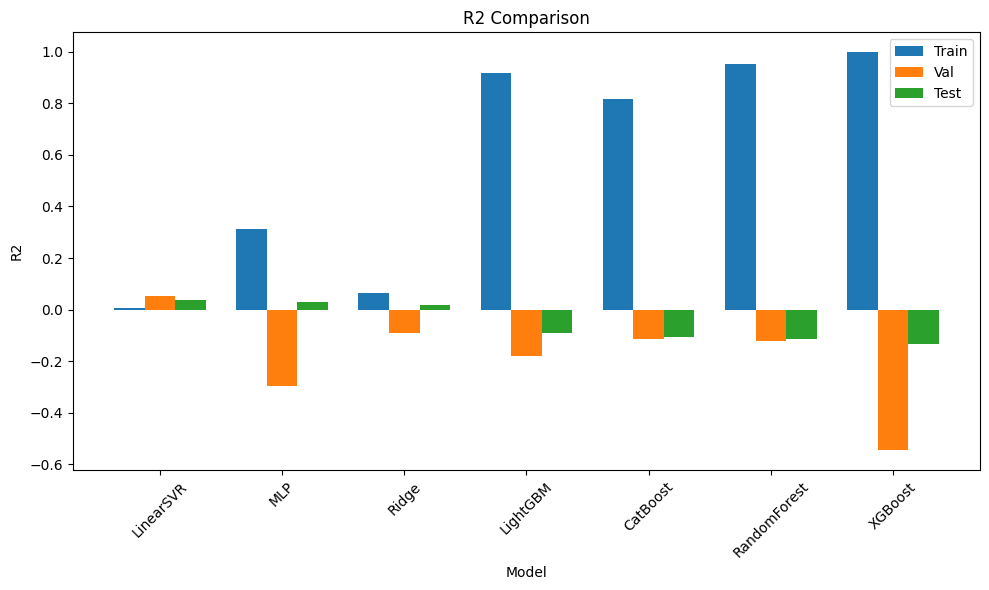

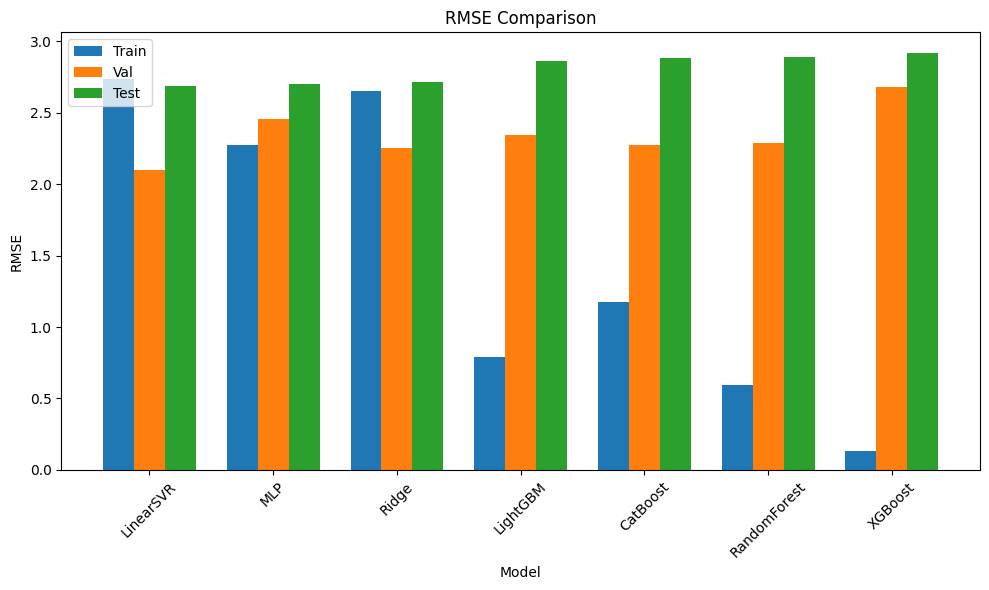

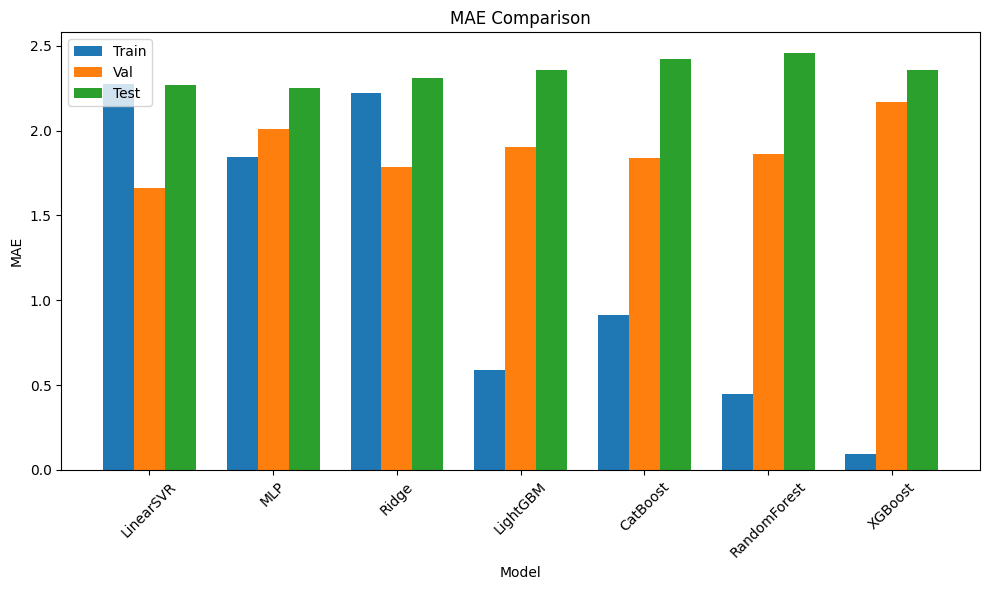


📋 전체 결과 요약:
          Model  R2_Train    R2_Val   R2_Test  RMSE_Train  RMSE_Val  \
0     LinearSVR  0.005342  0.054485  0.037274    2.735497  2.098099   
6           MLP  0.311806 -0.296607  0.029108    2.275385  2.456948   
1         Ridge  0.064859 -0.092087  0.018497    2.652394  2.254865   
4      LightGBM  0.917626 -0.180157 -0.091385    0.787217  2.344022   
5      CatBoost  0.816129 -0.113517 -0.104900    1.176132  2.276880   
2  RandomForest  0.952511 -0.122669 -0.113893    0.597721  2.286218   
3       XGBoost  0.997567 -0.544257 -0.133200    0.135297  2.681338   

   RMSE_Test  MAE_Train   MAE_Val  MAE_Test  
0   2.688147   2.276641  1.659442  2.269632  
6   2.699524   1.842966  2.011420  2.250901  
1   2.714236   2.218592  1.785689  2.309139  
4   2.862139   0.590990  1.904734  2.358002  
5   2.879806   0.915068  1.837221  2.423835  
2   2.891502   0.449852  1.861831  2.455921  
3   2.916453   0.094165  2.168246  2.358369  

🧩 사용된 Feature 목록:
          Model  Num Features  

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectKBest, f_regression

from tqdm import tqdm

# ✅ 데이터 준비 및 정규화
drop_cols = ['anxiety_mean', 'participant', 'start_idx']
X = window_df_all.drop(columns=drop_cols)
y = window_df_all['anxiety_mean'].values
participants = window_df_all['participant'].values

# NaN 처리
# X = X.dropna(axis=1, thresh=int(0.7 * len(X)))  # NaN 30% 이상인 열 제거
# X = X.fillna(X.mean())  # 나머지 평균 대체

# Participant 기준 split
# participant별 window 수 집계
participant_counts = pd.Series(participants).value_counts()
participant_counts = participant_counts.sample(frac=1, random_state=42)  # 셔플

# 목표 비율
total_windows = participant_counts.sum()
train_target = int(total_windows * 0.8)
val_target = int(total_windows * 0.1)

# participant 분배
train_pids, val_pids, test_pids = [], [], []
counts_cumsum = 0

for pid, count in participant_counts.items():
    if counts_cumsum < train_target:
        train_pids.append(pid)
    elif counts_cumsum < train_target + val_target:
        val_pids.append(pid)
    else:
        test_pids.append(pid)
    counts_cumsum += count

# 마스크 생성
train_mask = np.isin(participants, train_pids)
val_mask = np.isin(participants, val_pids)
test_mask = np.isin(participants, test_pids)

# split
X_train_raw, y_train = X[train_mask], y[train_mask]
X_val_raw, y_val = X[val_mask], y[val_mask]
X_test_raw, y_test = X[test_mask], y[test_mask]


# ✅ 정규화 (스케일링은 RFECV 전에 미리)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_raw), columns=X_val_raw.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns)

# ✅ 모델 정의 + RFECV 설정
models = {
    'LinearSVR': LinearSVR(max_iter=1000, random_state=42),
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=300, random_state=42),
    'CatBoost': CatBoostRegressor(n_estimators=300, random_state=42, verbose=0),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42, early_stopping=True)
}

rfecv_config = {
    'LinearSVR': {'use_rfecv': True, 'importance_getter': 'coef_'},
    'Ridge': {'use_rfecv': True, 'importance_getter': 'coef_'},
    'RandomForest': {'use_rfecv': True, 'importance_getter': 'feature_importances_'},
    'XGBoost': {'use_rfecv': True, 'importance_getter': 'feature_importances_'},
    'LightGBM': {'use_rfecv': True, 'importance_getter': 'feature_importances_'},
    'CatBoost': {'use_rfecv': True, 'importance_getter': 'feature_importances_'},
    'MLP': {'use_rfecv': False},  # 여전히 RFECV 불가
}

# 결과 저장 구조 동일
results = []
feature_info = []
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

print("🚀 모델 학습 및 평가 시작")

for name, model in tqdm(models.items(), desc="모델 진행 중"):
    print(f"\n⚙️  Feature selection for {name}...")

    config = rfecv_config[name]
    if config['use_rfecv']:
        try:
            rfecv = RFECV(
                estimator=model,
                step=1,
                cv=KFold(n_splits=3, shuffle=True, random_state=42),
                scoring='r2',
                n_jobs=-1,
                importance_getter=config['importance_getter']
            )
            rfecv.fit(X_train_scaled, y_train)
            X_train_sel = rfecv.transform(X_train_scaled)
            X_val_sel = rfecv.transform(X_val_scaled)
            X_test_sel = rfecv.transform(X_test_scaled)
            selected_features = X_train_scaled.columns[rfecv.support_]
            print(f"✅ {name} 완료 - 선택된 feature 수: {len(selected_features)}")
        except Exception as e:
            print(f"⚠️  {name} - RFECV 실패: {e}")
            X_train_sel = X_train_scaled
            X_val_sel = X_val_scaled
            X_test_sel = X_test_scaled
            selected_features = X_train_scaled.columns
    else:
        print(f"⚠️  {name} - RFECV 불가능, SelectKBest 사용")
        selector = SelectKBest(f_regression, k='all')
        selector.fit(X_train_scaled, y_train)
        X_train_sel = selector.transform(X_train_scaled)
        X_val_sel = selector.transform(X_val_scaled)
        X_test_sel = selector.transform(X_test_scaled)
        selected_features = X_train_scaled.columns[selector.get_support()]

    model.fit(X_train_sel, y_train)
    y_train_pred = model.predict(X_train_sel)
    y_val_pred = model.predict(X_val_sel)
    y_test_pred = model.predict(X_test_sel)

    results.append({
        'Model': name,
        'R2_Train': r2_score(y_train, y_train_pred),
        'R2_Val': r2_score(y_val, y_val_pred),
        'R2_Test': r2_score(y_test, y_test_pred),
        'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE_Val': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE_Train': mean_absolute_error(y_train, y_train_pred),
        'MAE_Val': mean_absolute_error(y_val, y_val_pred),
        'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    })

    feature_info.append({
        'Model': name,
        'Num Features': len(selected_features),
        'Features Used': list(selected_features)
    })
# ✅ 결과 정리 및 시각화
results_df = pd.DataFrame(results).sort_values(by='R2_Test', ascending=False)
feature_df = pd.DataFrame(feature_info)

metrics = ['R2', 'RMSE', 'MAE']
sets = ['Train', 'Val', 'Test']

os.makedirs("figures", exist_ok=True)
for metric in metrics:
    plt.figure(figsize=(10, 6))
    bar_width = 0.25
    index = np.arange(len(results_df))
    for i, subset in enumerate(sets):
        plt.bar(index + i * bar_width,
                results_df[f'{metric}_{subset}'],
                width=bar_width,
                label=subset)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(index + bar_width, results_df['Model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/{metric}_comparison_{timestamp}.png')
    plt.show()

# ✅ 출력
print("\n📋 전체 결과 요약:")
print(results_df)

print("\n🧩 사용된 Feature 목록:")
print(feature_df)


In [38]:
window_df_all

,pupilL_mean,pupilL_std,pupilR_mean,pupilR_std,PPG_Raw_mean,PPG_Raw_std,PPG_Clean_mean,PPG_Clean_std,PPG_Rate_mean,PPG_Rate_std,...,RSP_Symmetry_PeakTrough_std,RSP_Symmetry_RiseDecay_mean,RSP_Symmetry_RiseDecay_std,RSP_Peaks_mean,RSP_Peaks_std,RSP_Troughs_mean,RSP_Troughs_std,anxiety_mean,participant,start_idx
0,3.435810,0.641165,3.451648,0.465301,0.028877,0.711471,-0.007906,0.706272,83.408575,4.110505,...,0.167755,0.536260,0.097099,0.0,0.0,0.000833,0.028868,3.503426,bhk9709,0
1,3.366889,0.616587,3.352710,0.663058,-0.028025,0.754363,-0.019943,0.721095,80.566751,3.106603,...,0.120174,0.447316,0.014157,0.0,0.0,0.000000,0.000000,4.000000,bhk9709,600
2,3.624559,0.945132,3.578671,0.973521,0.038516,0.918913,-0.001039,0.679107,74.555075,7.334951,...,0.093191,0.491091,0.048721,0.0,0.0,0.000000,0.000000,4.000000,bhk9709,1200
3,3.568595,1.148032,3.562829,1.144504,0.092557,0.828369,0.015565,0.583354,74.716563,7.965097,...,0.103212,0.470691,0.083571,0.0,0.0,0.000000,0.000000,4.002346,bhk9709,1800
4,3.545791,1.181781,3.514154,1.192346,0.018151,0.670075,0.001661,0.600991,81.431829,6.285405,...,0.063687,0.421640,0.056608,0.0,0.0,0.000000,0.000000,4.007587,bhk9709,2400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,3.325356,1.060958,3.452451,0.889444,0.034698,0.367384,0.006521,0.323700,53.030200,17.241080,...,0.029038,0.381049,0.013760,0.0,0.0,0.000000,0.000000,6.382551,yjm0001,30000
7210,3.443572,0.966372,3.523903,0.471642,0.032366,0.268433,0.008134,0.222220,54.406992,18.555331,...,0.023920,0.383890,0.017097,0.0,0.0,0.000000,0.000000,6.448580,yjm0001,30600
7211,3.586095,0.944262,3.516051,0.605620,0.031390,0.250039,-0.002678,0.213978,70.856740,20.867001,...,0.022285,0.385467,0.018082,0.0,0.0,0.000000,0.000000,5.210154,yjm0001,31200
7212,3.723761,0.665343,3.545699,0.688744,0.041948,0.123365,0.000247,0.094926,62.406732,20.619454,...,0.026462,0.378897,0.019788,0.0,0.0,0.000000,0.000000,2.530432,yjm0001,31800


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from itertools import product
import numpy as np
import pandas as pd

# 참가자 split: 20%는 validation용
all_pids = np.unique(window_df_all['participant'].values)
np.random.seed(42)
val_pids = np.random.choice(all_pids, size=int(0.2 * len(all_pids)), replace=False)
train_pids = np.setdiff1d(all_pids, val_pids)

# 데이터 분리
X_train = window_df_all[window_df_all['participant'].isin(train_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_train = window_df_all[window_df_all['participant'].isin(train_pids)]['anxiety_mean'].values
X_val = window_df_all[window_df_all['participant'].isin(val_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_val = window_df_all[window_df_all['participant'].isin(val_pids)]['anxiety_mean'].values

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 튜닝 후보
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [3, 5, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [ 2, 4]
}

# 튜닝 수행
best_score = -np.inf
best_params = None
for combo in product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    model = RandomForestRegressor(**params, random_state=42)
    try:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        score = r2_score(y_val, y_val_pred)
        if score > best_score:
            best_score = score
            best_params = params
    except Exception as e:
        continue

print("✅ Best hyperparameters from validation:")
print(best_params)


✅ Best hyperparameters from validation:
{'n_estimators': 300, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 2}


In [43]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ✅ 수정된 전처리 함수
def prepare_lopo_data(df, test_pid, drop_cols=['participant', 'start_idx'], normalize=True, remove_baseline=True, remove_global_mean=False):
    train_mask = df['participant'] != test_pid
    test_mask = df['participant'] == test_pid

    # Drop target and meta columns from X
    all_drop = ['anxiety_mean'] + drop_cols
    feature_cols = df.drop(columns=all_drop).select_dtypes(include=[np.number]).columns

    X_train = df.loc[train_mask, feature_cols].copy()
    y_train = df.loc[train_mask, 'anxiety_mean'].copy()
    X_test = df.loc[test_mask, feature_cols].copy()
    y_test = df.loc[test_mask, 'anxiety_mean'].copy()

    # 1. NaN / inf 제거
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    valid_train_rows = X_train.notna().all(axis=1)
    valid_test_rows = X_test.notna().all(axis=1)

    X_train = X_train[valid_train_rows]
    y_train = y_train[valid_train_rows]
    X_test = X_test[valid_test_rows]
    y_test = y_test[valid_test_rows]

    # 2. 표준편차 0인 feature 제거
    stds = X_train.std()
    nonzero_features = stds[stds > 0].index
    X_train = X_train[nonzero_features]
    X_test = X_test[nonzero_features]

    # 3. Normalization
    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # 4. Baseline 제거
    if remove_baseline:
        participant_means = df.groupby('participant')['anxiety_mean'].mean()
        baseline = participant_means[test_pid]
        y_train = y_train - baseline
        y_test = y_test - baseline

    # 5. Global mean 제거
    if remove_global_mean:
        global_mean = df['anxiety_mean'].mean()
        y_train = y_train - global_mean
        y_test = y_test - global_mean

    return X_train, y_train.values, X_test, y_test.values

# ✅ 모델 학습 및 평가
def run_lopo_evaluation(df, all_pids, best_params, normalize=True, remove_baseline=True, remove_global_mean=False):
    results = []

    for test_pid in tqdm(all_pids, desc="LOPO"):
        X_train, y_train, X_test, y_test = prepare_lopo_data(
            df, test_pid,
            normalize=normalize,
            remove_baseline=remove_baseline,
            remove_global_mean=remove_global_mean
        )

        if len(X_train) == 0 or len(X_test) == 0:
            print(f"⚠️ Skipping PID {test_pid} due to empty data after cleaning")
            continue

        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results.append({
            'TestPID': test_pid,
            'R2': r2_score(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred)
        })

    return pd.DataFrame(results)

# ✅ 실행
# best_params는 이전 하이퍼파라미터 튜닝 결과 사용
# 예시:
# best_params = {'n_estimators': 300, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 2}

rf_lopo_df = run_lopo_evaluation(
    df=window_df_all,
    all_pids=window_df_all['participant'].unique(),
    best_params=best_params,
    normalize=True,
    remove_baseline=True,
    remove_global_mean=True  # 이 옵션은 baseline 제거한 후 전체 평균까지 제거할 때 True로
)

# ✅ 요약
summary = {
    'N': len(rf_lopo_df),
    'Mean R2': rf_lopo_df['R2'].mean(),
    'Mean RMSE': rf_lopo_df['RMSE'].mean(),
    'Mean MAE': rf_lopo_df['MAE'].mean()
}
print("\n📊 LOPO 결과 요약:")
print(pd.DataFrame([summary]))


LOPO:   0%|          | 0/107 [00:00<?, ?it/s]

LOPO: 100%|██████████| 107/107 [03:45<00:00,  2.11s/it]


📊 LOPO 결과 요약:
     N   Mean R2  Mean RMSE  Mean MAE
0  107 -7.142096   2.528163  2.249167


### Ridge

In [61]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm

# 하이퍼파라미터 후보 (알파값은 정규화 세기)
alphas = np.logspace(-3, 3, 10)  # 0.001 ~ 1000

# 결과 저장
ridge_lopo_results = []

# 참가자 목록
all_pids = np.unique(window_df_all['participant'].values)

# LOPO 실행
for test_pid in tqdm(all_pids, desc="Ridge LOPO"):
    # Train/Test 분리
    train_mask = window_df_all['participant'] != test_pid
    test_mask = window_df_all['participant'] == test_pid

    X_train = window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_train = window_df_all[train_mask]['anxiety_mean'].values
    X_test = window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_test = window_df_all[test_mask]['anxiety_mean'].values

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # RidgeCV 학습
    ridge = RidgeCV(alphas=alphas, scoring='r2')
    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_test_scaled)

    # 성능 저장
    ridge_lopo_results.append({
        'TestPID': test_pid,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'BestAlpha': ridge.alpha_
    })

# 결과 정리
ridge_lopo_df = pd.DataFrame(ridge_lopo_results)
summary = {
    'N': len(ridge_lopo_df),
    'Mean R2': ridge_lopo_df['R2'].mean(),
    'Mean RMSE': ridge_lopo_df['RMSE'].mean(),
    'Mean MAE': ridge_lopo_df['MAE'].mean()
}

print("\n📊 Ridge LOPO 결과 요약:")
print(pd.DataFrame([summary]))


Ridge LOPO: 100%|██████████| 107/107 [00:05<00:00, 19.73it/s]


📊 Ridge LOPO 결과 요약:
     N    Mean R2  Mean RMSE  Mean MAE
0  107 -12.463082   2.551526  2.264099


### SVM

In [62]:
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tqdm import tqdm

# 📌 참가자 분할
all_pids = np.unique(window_df_all['participant'].values)
np.random.seed(42)
val_pids = np.random.choice(all_pids, size=int(0.2 * len(all_pids)), replace=False)
train_pids = np.setdiff1d(all_pids, val_pids)

# 데이터 분리
X_train = window_df_all[window_df_all['participant'].isin(train_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_train = window_df_all[window_df_all['participant'].isin(train_pids)]['anxiety_mean'].values
X_val = window_df_all[window_df_all['participant'].isin(val_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_val = window_df_all[window_df_all['participant'].isin(val_pids)]['anxiety_mean'].values

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ✅ 하이퍼파라미터 그리드
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2],
    'kernel': ['linear', 'rbf']
}

best_score = -np.inf
best_params = None

# 🔍 Validation을 통한 튜닝
for params in ParameterGrid(param_grid):
    model = SVR(**params)
    try:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        score = r2_score(y_val, y_val_pred)
        if score > best_score:
            best_score = score
            best_params = params
    except:
        continue

print("✅ Best SVR params:", best_params)

# 🧪 LOPO with best SVR model
svr_lopo_results = []

for test_pid in tqdm(all_pids, desc="LOPO-SVR"):
    train_mask = window_df_all['participant'] != test_pid
    test_mask = window_df_all['participant'] == test_pid

    X_train = window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_train = window_df_all[train_mask]['anxiety_mean'].values
    X_test = window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_test = window_df_all[test_mask]['anxiety_mean'].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(**best_params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    svr_lopo_results.append({
        'TestPID': test_pid,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

svr_lopo_df = pd.DataFrame(svr_lopo_results)
summary = {
    'N': len(svr_lopo_df),
    'Mean R2': svr_lopo_df['R2'].mean(),
    'Mean RMSE': svr_lopo_df['RMSE'].mean(),
    'Mean MAE': svr_lopo_df['MAE'].mean()
}

print("\n📊 LOPO-SVR 결과 요약:")
print(pd.DataFrame([summary]))


✅ Best SVR params: {'C': 0.1, 'epsilon': 0.2, 'kernel': 'rbf'}


LOPO-SVR: 100%|██████████| 107/107 [00:29<00:00,  3.60it/s]


📊 LOPO-SVR 결과 요약:
     N    Mean R2  Mean RMSE  Mean MAE
0  107 -12.011134   2.409937  2.146599


### Catboost

In [63]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tqdm import tqdm

# 참가자 분할
all_pids = np.unique(window_df_all['participant'].values)
np.random.seed(42)
val_pids = np.random.choice(all_pids, size=int(0.2 * len(all_pids)), replace=False)
train_pids = np.setdiff1d(all_pids, val_pids)

# 데이터 분리
X_train = window_df_all[window_df_all['participant'].isin(train_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_train = window_df_all[window_df_all['participant'].isin(train_pids)]['anxiety_mean'].values
X_val = window_df_all[window_df_all['participant'].isin(val_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_val = window_df_all[window_df_all['participant'].isin(val_pids)]['anxiety_mean'].values

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 파라미터 그리드
param_grid = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5]
}

best_score = -np.inf
best_params = None

# validation 기반 튜닝
for params in ParameterGrid(param_grid):
    model = CatBoostRegressor(verbose=0, random_state=42, **params)
    try:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        score = r2_score(y_val, y_val_pred)
        if score > best_score:
            best_score = score
            best_params = params
    except Exception as e:
        continue

print("✅ Best CatBoost params:", best_params)

# LOPO 평가
catboost_lopo_results = []

for test_pid in tqdm(all_pids, desc="LOPO-CatBoost"):
    train_mask = window_df_all['participant'] != test_pid
    test_mask = window_df_all['participant'] == test_pid

    X_train = window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_train = window_df_all[train_mask]['anxiety_mean'].values
    X_test = window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_test = window_df_all[test_mask]['anxiety_mean'].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = CatBoostRegressor(verbose=0, random_state=42, **best_params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    catboost_lopo_results.append({
        'TestPID': test_pid,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

catboost_lopo_df = pd.DataFrame(catboost_lopo_results)
summary = {
    'N': len(catboost_lopo_df),
    'Mean R2': catboost_lopo_df['R2'].mean(),
    'Mean RMSE': catboost_lopo_df['RMSE'].mean(),
    'Mean MAE': catboost_lopo_df['MAE'].mean()
}

print("\n📊 LOPO-CatBoost 결과 요약:")
print(pd.DataFrame([summary]))


✅ Best CatBoost params: {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


LOPO-CatBoost: 100%|██████████| 107/107 [04:26<00:00,  2.49s/it]


📊 LOPO-CatBoost 결과 요약:
     N    Mean R2  Mean RMSE  Mean MAE
0  107 -11.726884     2.5492  2.277661


In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 참가자 split
all_pids = np.unique(window_df_all['participant'])
np.random.seed(42)
val_pids = np.random.choice(all_pids, size=int(0.2 * len(all_pids)), replace=False)
train_pids = np.setdiff1d(all_pids, val_pids)

# train/val 분리
X_train = window_df_all[window_df_all['participant'].isin(train_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_train = window_df_all[window_df_all['participant'].isin(train_pids)]['anxiety_mean'].values
X_val = window_df_all[window_df_all['participant'].isin(val_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_val = window_df_all[window_df_all['participant'].isin(val_pids)]['anxiety_mean'].values

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### GradientBoostingRegressor

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

best_score = -np.inf
best_params = None
for params in ParameterGrid(param_grid):
    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    score = r2_score(y_val, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

print("✅ Best params (GBRT):", best_params)

# LOPO
gbrt_results = []
for pid in tqdm(all_pids, desc="LOPO - GBRT"):
    train_mask = window_df_all['participant'] != pid
    test_mask = window_df_all['participant'] == pid

    X_tr = scaler.transform(window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_tr = window_df_all[train_mask]['anxiety_mean'].values
    X_te = scaler.transform(window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_te = window_df_all[test_mask]['anxiety_mean'].values

    model = GradientBoostingRegressor(**best_params, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    gbrt_results.append({
        'TestPID': pid,
        'R2': r2_score(y_te, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
        'MAE': mean_absolute_error(y_te, y_pred)
    })

gbrt_df = pd.DataFrame(gbrt_results)
print("\n📊 LOPO-GBRT 결과 요약:")
print(pd.DataFrame([{
    'N': len(gbrt_df),
    'Mean R2': gbrt_df['R2'].mean(),
    'Mean RMSE': gbrt_df['RMSE'].mean(),
    'Mean MAE': gbrt_df['MAE'].mean()
}]))


✅ Best params (GBRT): {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


LOPO - GBRT: 100%|██████████| 107/107 [09:21<00:00,  5.25s/it]


📊 LOPO-GBRT 결과 요약:
     N    Mean R2  Mean RMSE  Mean MAE
0  107 -10.631299   2.428254  2.162752


### MLP Regressor

In [66]:
from sklearn.neural_network import MLPRegressor

# 하이퍼파라미터 튜닝
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

best_score = -np.inf
best_params = None
for params in ParameterGrid(param_grid):
    model = MLPRegressor(max_iter=500, random_state=42, **params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    score = r2_score(y_val, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

print("✅ Best params (MLP):", best_params)

# LOPO
mlp_results = []
for pid in tqdm(all_pids, desc="LOPO - MLP"):
    train_mask = window_df_all['participant'] != pid
    test_mask = window_df_all['participant'] == pid

    X_tr = scaler.transform(window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_tr = window_df_all[train_mask]['anxiety_mean'].values
    X_te = scaler.transform(window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_te = window_df_all[test_mask]['anxiety_mean'].values

    model = MLPRegressor(max_iter=500, random_state=42, **best_params)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    mlp_results.append({
        'TestPID': pid,
        'R2': r2_score(y_te, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
        'MAE': mean_absolute_error(y_te, y_pred)
    })

mlp_df = pd.DataFrame(mlp_results)
print("\n📊 LOPO-MLP 결과 요약:")
print(pd.DataFrame([{
    'N': len(mlp_df),
    'Mean R2': mlp_df['R2'].mean(),
    'Mean RMSE': mlp_df['RMSE'].mean(),
    'Mean MAE': mlp_df['MAE'].mean()
}]))


c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ Best params (MLP): {'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}


LOPO - MLP: 100%|██████████| 107/107 [02:06<00:00,  1.18s/it]


📊 LOPO-MLP 결과 요약:
     N    Mean R2  Mean RMSE  Mean MAE
0  107 -26.978914   3.416415  2.947746


### LGBMRegrassor

In [67]:
!pip install lightgbm

In [68]:
from lightgbm import LGBMRegressor

# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

best_score = -np.inf
best_params = None
for params in ParameterGrid(param_grid):
    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    score = r2_score(y_val, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

print("✅ Best params (LGBM):", best_params)

# LOPO
lgbm_results = []
for pid in tqdm(all_pids, desc="LOPO - LGBM"):
    train_mask = window_df_all['participant'] != pid
    test_mask = window_df_all['participant'] == pid

    X_tr = scaler.transform(window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_tr = window_df_all[train_mask]['anxiety_mean'].values
    X_te = scaler.transform(window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_te = window_df_all[test_mask]['anxiety_mean'].values

    model = LGBMRegressor(**best_params, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    lgbm_results.append({
        'TestPID': pid,
        'R2': r2_score(y_te, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
        'MAE': mean_absolute_error(y_te, y_pred)
    })

lgbm_df = pd.DataFrame(lgbm_results)
print("\n📊 LOPO-LGBM 결과 요약:")
print(pd.DataFrame([{
    'N': len(lgbm_df),
    'Mean R2': lgbm_df['R2'].mean(),
    'Mean RMSE': lgbm_df['RMSE'].mean(),
    'Mean MAE': lgbm_df['MAE'].mean()
}]))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10144
[LightGBM] [Info] Number of data points in the train set: 1826, number of used features: 58
[LightGBM] [Info] Start training from score 5.376788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10144
[LightGBM] [Info] Number of data points in the train set: 1826, number of used features: 58
[LightGBM] [Info] Start training from score 5.376788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LOPO - LGBM:   0%|          | 0/107 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10223
[LightGBM] [Info] Number of data points in the train set: 2278, number of used features: 58
[LightGBM] [Info] Start training from score 5.379197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:   2%|▏         | 2/107 [00:00<00:07, 14.51it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:   4%|▎         | 4/107 [00:00<00:07, 14.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10227
[LightGBM] [Info] Number of data points in the train set: 2289, number of used features: 58
[LightGBM] [Info] Start training from score 5.370087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:   6%|▌         | 6/107 [00:00<00:06, 14.43it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10223
[LightGBM] [Info] Number of data points in the train set: 2273, number of used features: 58
[LightGBM] [Info] Start training from score 5.327021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:   7%|▋         | 8/107 [00:00<00:07, 13.88it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10225
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 58
[LightGBM] [Info] Start training from score 5.344928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:   9%|▉         | 10/107 [00:00<00:06, 14.23it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10228
[LightGBM] [Info] Number of data points in the train set: 2285, number of used features: 58
[LightGBM] [Info] Start training from score 5.369079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LOPO - LGBM:  11%|█         | 12/107 [00:00<00:06, 14.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10229
[LightGBM] [Info] Number of data points in the train set: 2285, number of used features: 58
[LightGBM] [Info] Start training from score 5.381821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  13%|█▎        | 14/107 [00:00<00:06, 14.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10228
[LightGBM] [Info] Number of data points in the train set: 2279, number of used features: 58
[LightGBM] [Info] Start training from score 5.366539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10224
[LightGBM] [Info] Number of data points in the train set: 2264, number of used features: 58
[LightGBM] [Info] Start training from score 5.365559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  15%|█▍        | 16/107 [00:01<00:06, 13.83it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  17%|█▋        | 18/107 [00:01<00:07, 11.76it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  19%|█▊        | 20/107 [00:01<00:07, 12.25it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10229
[LightGBM] [Info] Number of data points in the train set: 2280, number of used features: 58
[LightGBM] [Info] Start training from score 5.369332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  21%|██        | 22/107 [00:01<00:06, 12.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10228
[LightGBM] [Info] Number of data points in the train set: 2285, number of used features: 58
[LightGBM] [Info] Start training from score 5.376170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  22%|██▏       | 24/107 [00:01<00:06, 12.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10228
[LightGBM] [Info] Number of data points in the train set: 2285, number of used features: 58
[LightGBM] [Info] Start training from score 5.382679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10224
[LightGBM] [Info] Number of data points in the train set: 2283, number of used features: 58
[LightGBM] [Info] Start training from score 5.386631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  24%|██▍       | 26/107 [00:01<00:06, 12.88it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10224
[LightGBM] [Info] Number of data points in the train set: 2282, number of used features: 58
[LightGBM] [Info] Start training from score 5.374615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  26%|██▌       | 28/107 [00:02<00:06, 13.11it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10228
[LightGBM] [Info] Number of data points in the train set: 2287, number of used features: 58
[LightGBM] [Info] Start training from score 5.364635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  28%|██▊       | 30/107 [00:02<00:05, 13.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10228
[LightGBM] [Info] Number of data points in the train set: 2288, number of used features: 58
[LightGBM] [Info] Start training from score 5.363317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10223
[LightGBM] [Info] Number of data points in the train 

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  30%|██▉       | 32/107 [00:02<00:05, 13.20it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10229
[LightGBM] [Info] Number of data points in the train set: 2289, number of used features: 58
[LightGBM] [Info] Start training from score 5.354728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  32%|███▏      | 34/107 [00:02<00:05, 13.58it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  34%|███▎      | 36/107 [00:02<00:05, 13.76it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10227
[LightGBM] [Info] Number of data points in the train set: 2282, number of used features: 58
[LightGBM] [Info] Start training from score 5.385903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  36%|███▌      | 38/107 [00:02<00:05, 13.79it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  37%|███▋      | 40/107 [00:02<00:04, 13.99it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  39%|███▉      | 42/107 [00:03<00:04, 14.31it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  41%|████      | 44/107 [00:03<00:04, 14.34it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  43%|████▎     | 46/107 [00:03<00:04, 14.30it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  45%|████▍     | 48/107 [00:03<00:04, 14.21it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  47%|████▋     | 50/107 [00:03<00:03, 14.32it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  49%|████▊     | 52/107 [00:03<00:03, 14.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10214
[LightGBM] [Info] Number of data points in the train set: 2270, number of used features: 58
[LightGBM] [Info] Start training from score 5.343314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  50%|█████     | 54/107 [00:03<00:03, 14.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  52%|█████▏    | 56/107 [00:04<00:04, 12.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  54%|█████▍    | 58/107 [00:04<00:03, 13.03it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  56%|█████▌    | 60/107 [00:04<00:03, 13.57it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  58%|█████▊    | 62/107 [00:04<00:03, 14.00it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  60%|█████▉    | 64/107 [00:04<00:03, 13.70it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  62%|██████▏   | 66/107 [00:04<00:02, 13.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10224
[LightGBM] [Info] Number of data points in the train set: 2286, number of used features: 58
[LightGBM] [Info] Start training from score 5.354042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  64%|██████▎   | 68/107 [00:04<00:02, 14.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10229
[LightGBM] [Info] Number of data points in the train set: 2257, number of used features: 58
[LightGBM] [Info] Start training from score 5.364431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  65%|██████▌   | 70/107 [00:05<00:02, 14.38it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  67%|██████▋   | 72/107 [00:05<00:02, 14.55it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  69%|██████▉   | 74/107 [00:05<00:02, 13.70it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  71%|███████   | 76/107 [00:05<00:02, 13.97it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  73%|███████▎  | 78/107 [00:05<00:02, 14.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10225
[LightGBM] [Info] Number of data points in the train set: 2272, number of used features: 58
[LightGBM] [Info] Start training from score 5.355753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  75%|███████▍  | 80/107 [00:05<00:01, 14.36it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  77%|███████▋  | 82/107 [00:06<00:01, 12.91it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  79%|███████▊  | 84/107 [00:06<00:01, 13.06it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  80%|████████  | 86/107 [00:06<00:01, 13.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  82%|████████▏ | 88/107 [00:06<00:01, 13.79it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  84%|████████▍ | 90/107 [00:06<00:01, 13.77it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  86%|████████▌ | 92/107 [00:06<00:01, 13.69it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  88%|████████▊ | 94/107 [00:06<00:00, 13.91it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10224
[LightGBM] [Info] Number of data points in the train set: 2284, number of used features: 58
[LightGBM] [Info] Start training from score 5.366684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  90%|████████▉ | 96/107 [00:07<00:00, 13.74it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10215
[LightGBM] [Info] Number of data points in the train set: 2271, number of used features: 58
[LightGBM] [Info] Start training from score 5.340748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  92%|█████████▏| 98/107 [00:07<00:00, 13.98it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  93%|█████████▎| 100/107 [00:07<00:00, 14.35it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10228
[LightGBM] [Info] Number of data points in the train set: 2288, number of used features: 58
[LightGBM] [Info] Start training from score 5.383013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  95%|█████████▌| 102/107 [00:07<00:00, 14.38it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10229
[LightGBM] [Info] Number of data points in the train set: 2272, number of used features: 58
[LightGBM] [Info] Start training from score 5.358497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  97%|█████████▋| 104/107 [00:07<00:00, 13.50it/s]c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM:  99%|█████████▉| 106/107 [00:07<00:00, 13.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10226
[LightGBM] [Info] Number of data points in the train set: 2284, number of used features: 58
[LightGBM] [Info] Start training from score 5.351971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LOPO - LGBM: 100%|██████████| 107/107 [00:07<00:00, 13.71it/s]


📊 LOPO-LGBM 결과 요약:
     N    Mean R2  Mean RMSE  Mean MAE
0  107 -10.557354   2.374405  2.117661


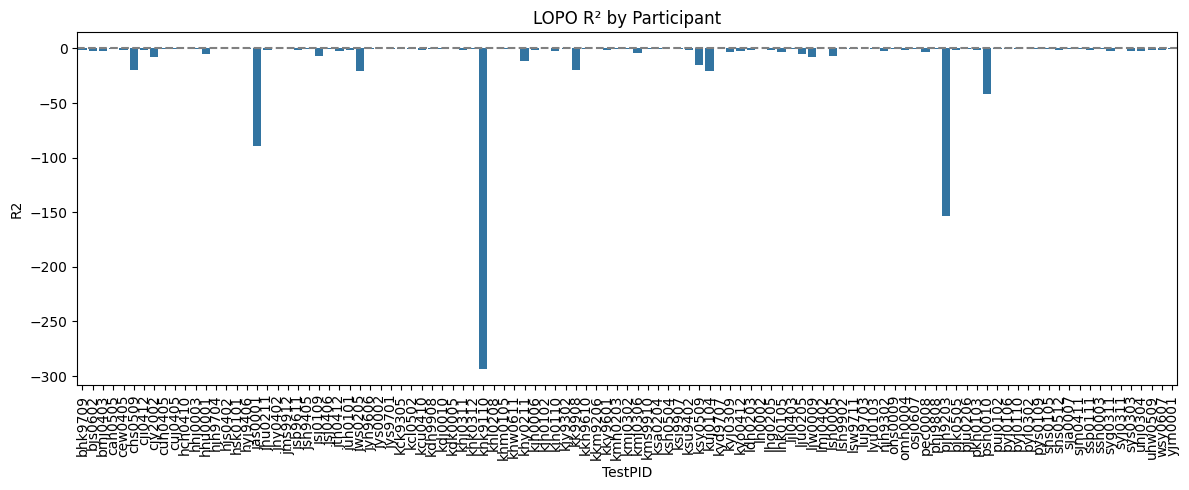

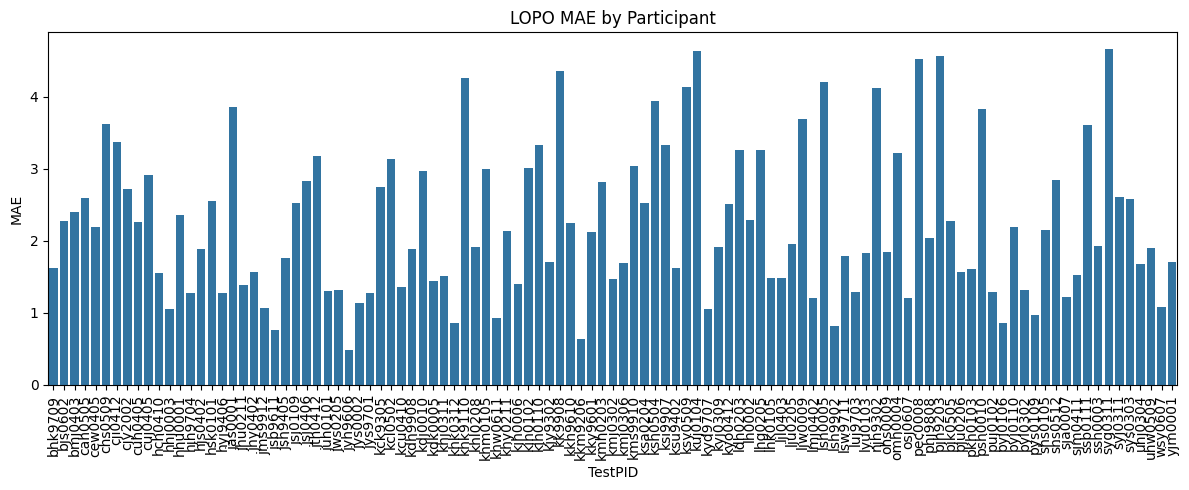

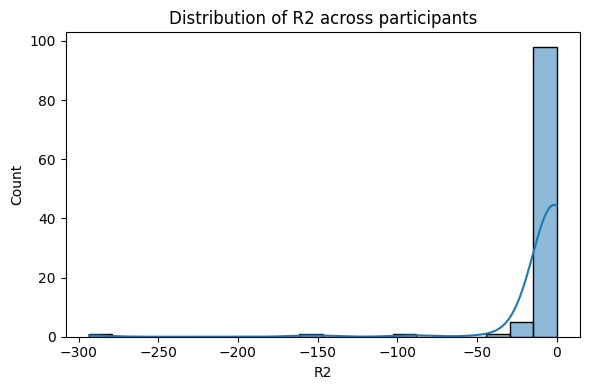

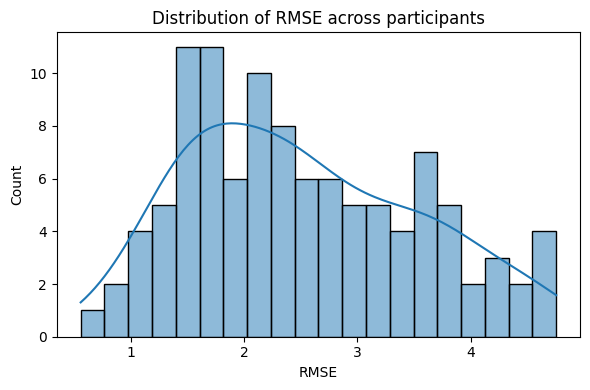

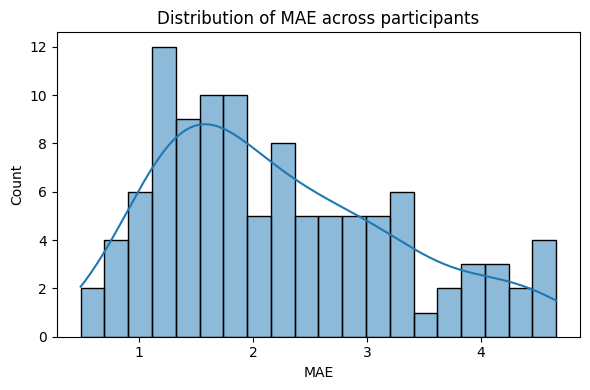

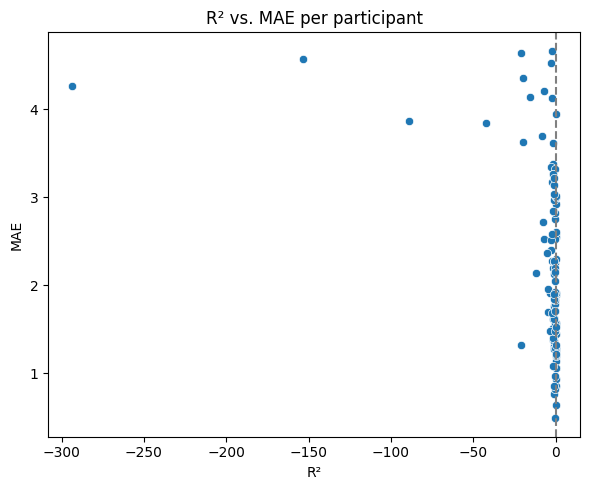

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# R² by TestPID
plt.figure(figsize=(12, 5))
sns.barplot(x='TestPID', y='R2', data=rf_lopo_df)
plt.title('LOPO R² by Participant')
plt.xticks(rotation=90)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# MAE by TestPID
plt.figure(figsize=(12, 5))
sns.barplot(x='TestPID', y='MAE', data=rf_lopo_df)
plt.title('LOPO MAE by Participant')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

metrics = ['R2', 'RMSE', 'MAE']
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(rf_lopo_df[metric], kde=True, bins=20)
    plt.title(f'Distribution of {metric} across participants')
    plt.xlabel(metric)
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize=(6, 5))
sns.scatterplot(x='R2', y='MAE', data=rf_lopo_df)
plt.title('R² vs. MAE per participant')
plt.xlabel('R²')
plt.ylabel('MAE')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


### Difference

In [50]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def extract_diff_features(window_df_all, raw_df_dict, feature_cols, window_size_sec=30, sampling_rate=120):
    """
    각 window에 대해 변화량 기반 feature(diff/slope)를 계산하여 새 DataFrame 반환
    - window_df_all: 각 row가 window 하나인 DataFrame
    - raw_df_dict: participant별 raw 시계열 DataFrame dict
    - feature_cols: 변화량 계산할 컬럼 리스트
    - window_size_sec: 윈도우 크기 (초)
    - sampling_rate: physiology 샘플링 속도 (Hz)
    """
    new_records = []

    for idx, row in window_df_all.iterrows():
        pid = row['participant']
        start_idx = int(row['start_idx'])
        end_idx = start_idx + window_size_sec * sampling_rate

        raw_df = raw_df_dict[pid]
        window_raw = raw_df.iloc[start_idx:end_idx]

        record = {
            'participant': pid,
            'start_idx': start_idx,
            'anxiety_mean': row['anxiety_mean'],
            'scene': row.get('scene', None)
        }

        for col in feature_cols:
            if col in window_raw.columns:
                series = window_raw[col].values

                # 1. 단순 차이
                record[f'diff_{col}'] = series[-1] - series[0]

                # 2. 선형 회귀 slope (optional)
                x = np.arange(len(series)).reshape(-1, 1)
                y = series.reshape(-1, 1)
                if np.any(np.isnan(y)) or np.any(np.isinf(y)):
                    slope = np.nan
                else:
                    model = LinearRegression()
                    model.fit(x, y)
                    slope = model.coef_[0][0]
                record[f'slope_{col}'] = slope

        new_records.append(record)

    # 새롭게 만든 변화량 기반 DataFrame
    diff_df = pd.DataFrame(new_records)
    return diff_df


In [54]:
# 사용할 feature 컬럼 정의
feature_cols = [col for col in data_dict['bjs0602'].columns if col.startswith(('EDA_', 'PPG_', 'RSP_'))]

# diff/slope 기반 새 데이터 생성
window_df_diff = extract_diff_features(
    window_df_all=window_df_all,
    raw_df_dict=data_dict,
    feature_cols=feature_cols,
    window_size_sec=30,
    sampling_rate=120
)


In [55]:
window_df_diff

,participant,start_idx,anxiety_mean,scene,diff_PPG_Raw,slope_PPG_Raw,diff_PPG_Clean,slope_PPG_Clean,diff_PPG_Rate,slope_PPG_Rate,...,diff_RSP_Phase_Completion,slope_RSP_Phase_Completion,diff_RSP_Symmetry_PeakTrough,slope_RSP_Symmetry_PeakTrough,diff_RSP_Symmetry_RiseDecay,slope_RSP_Symmetry_RiseDecay,diff_RSP_Peaks,slope_RSP_Peaks,diff_RSP_Troughs,slope_RSP_Troughs
0,bhk9709,0,3.837004,None,0.101624,-7.589277e-06,0.124481,1.698317e-06,6.723279,-0.000924,...,-0.367298,-0.000001,-0.287765,0.000003,-0.048153,-0.000045,0.0,0.000000e+00,0.0,-4.422583e-07
1,bhk9709,1800,3.888736,None,0.118103,-4.264690e-05,-0.083207,-1.271537e-05,0.309137,0.002273,...,0.202675,0.000011,-0.417526,-0.000135,-0.217886,0.000009,0.0,0.000000e+00,0.0,0.000000e+00
2,bhk9709,3600,3.391622,None,1.276550,-6.933694e-06,1.065851,7.958467e-07,-7.512113,-0.001472,...,0.023865,-0.000001,0.065470,0.000083,-0.138303,-0.000065,0.0,1.651235e-07,0.0,1.171554e-07
3,bhk9709,5400,2.922267,None,-0.244446,8.639905e-07,-0.255630,1.400251e-06,2.331265,-0.000581,...,-0.625835,0.000010,0.146424,-0.000021,0.181243,0.000032,0.0,-7.608025e-07,0.0,-3.458076e-07
4,bhk9709,7200,2.614383,None,-1.083374,6.071996e-06,-1.184980,4.661584e-06,-2.653138,-0.002062,...,0.009677,-0.000009,-0.172358,-0.000003,0.150018,0.000062,0.0,0.000000e+00,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,yjm0001,21600,4.295785,None,0.195312,1.024177e-06,0.218623,2.478401e-06,-2.918241,0.001073,...,-0.220638,0.000004,0.092944,0.000026,0.102117,0.000004,0.0,0.000000e+00,0.0,1.590792e-07
2296,yjm0001,23400,4.723347,None,0.005493,5.275839e-06,-0.094754,2.596015e-06,7.024533,0.002540,...,-0.925453,0.000012,0.059257,0.000008,0.105437,0.000049,0.0,0.000000e+00,0.0,-3.038838e-07
2297,yjm0001,25200,4.965302,None,-0.537720,1.180893e-06,-0.422672,8.454602e-06,-9.790662,-0.000358,...,0.031733,0.000006,0.015670,-0.000010,-0.025113,-0.000042,0.0,0.000000e+00,0.0,0.000000e+00
2298,yjm0001,27000,5.240357,None,-0.126953,7.934600e-07,0.050734,-3.567776e-06,-40.964517,-0.007743,...,0.093659,0.000009,-0.080047,-0.000039,-0.101857,-0.000022,0.0,0.000000e+00,0.0,0.000000e+00


In [57]:
# 불필요한 column 제거 기준 정의
exclude_keywords = ['unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos', 'X_rot', 'Y_rot', 'Z_rot',
                    'validL', 'validR', 'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
                    'eye_openness']

# 사용 가능한 feature column 추출
valid_feature_cols = [
    col for col in window_df_diff.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_diff[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]


In [58]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# 전체 데이터 사용
X = window_df_diff[valid_feature_cols]
y = window_df_diff['anxiety_mean'].values

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_grid, n_iter=30, cv=3, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(X_scaled, y)

best_params = random_search.best_params_
print("✅ Best RF Params:")
print(best_params)


✅ Best RF Params:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}


In [59]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm

rf_lopo_results = []

for test_pid in tqdm(window_df_diff['participant'].unique(), desc="LOPO with diff features"):
    train_mask = window_df_diff['participant'] != test_pid
    test_mask = window_df_diff['participant'] == test_pid

    X_train = window_df_diff.loc[train_mask, valid_feature_cols]
    y_train = window_df_diff.loc[train_mask, 'anxiety_mean'].values
    X_test = window_df_diff.loc[test_mask, valid_feature_cols]
    y_test = window_df_diff.loc[test_mask, 'anxiety_mean'].values

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rf_lopo_results.append({
        'TestPID': test_pid,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

rf_lopo_df = pd.DataFrame(rf_lopo_results)

summary = {
    'N': len(rf_lopo_df),
    'Mean R2': rf_lopo_df['R2'].mean(),
    'Mean RMSE': rf_lopo_df['RMSE'].mean(),
    'Mean MAE': rf_lopo_df['MAE'].mean()
}

print("\n📊 LOPO 결과 요약:")
print(pd.DataFrame([summary]))


LOPO with diff features: 100%|██████████| 107/107 [02:50<00:00,  1.60s/it]


📊 LOPO 결과 요약:
     N    Mean R2  Mean RMSE  Mean MAE
0  107 -10.940381   2.354834  2.099141


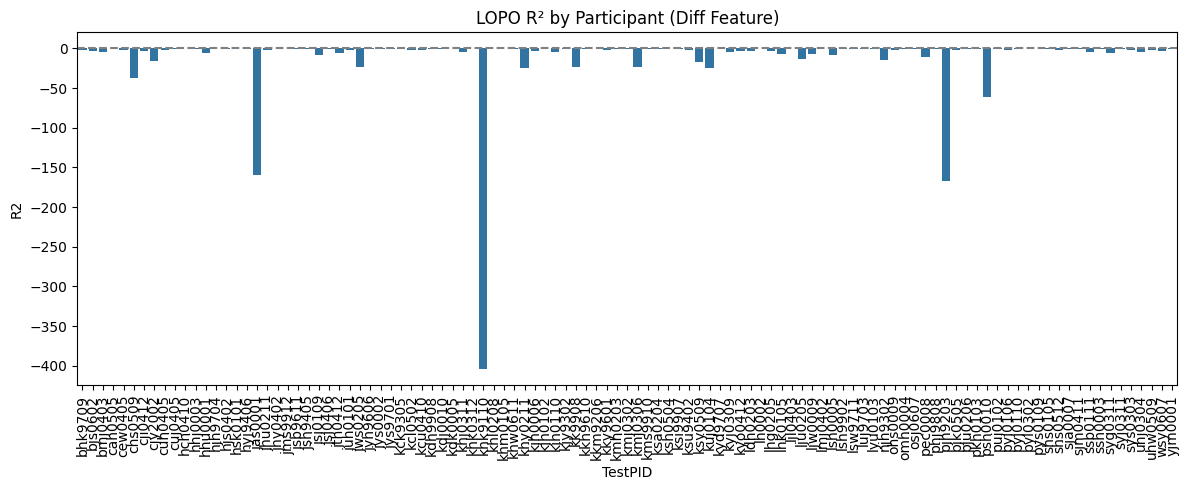

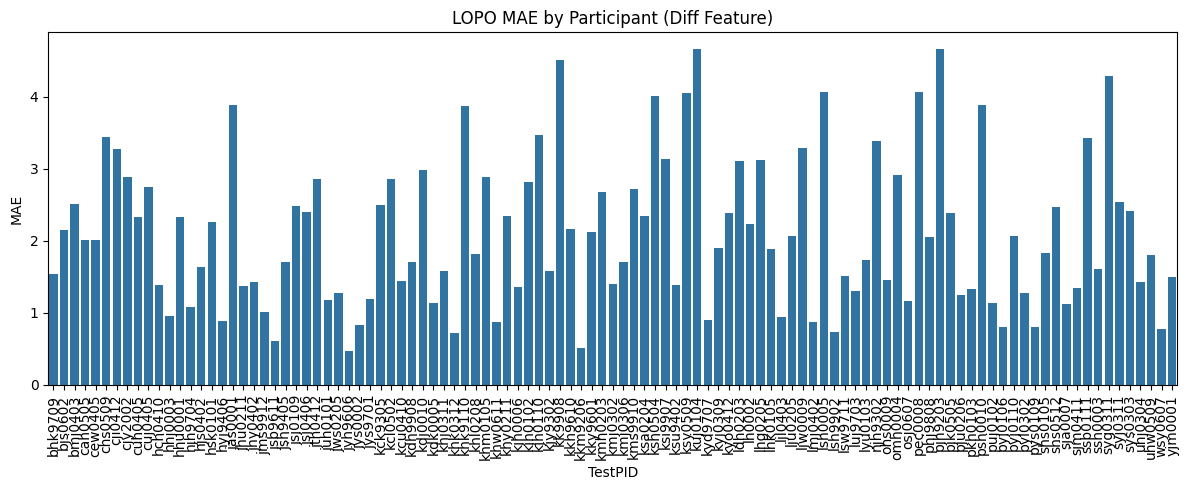

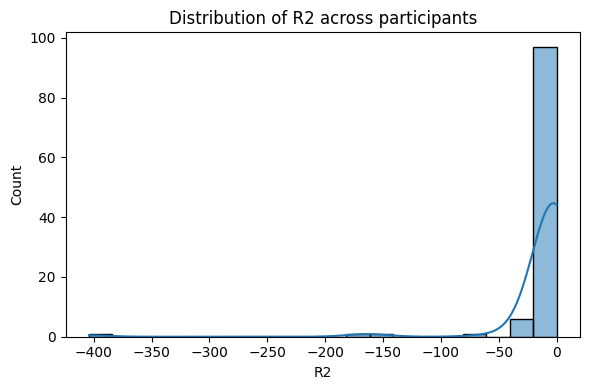

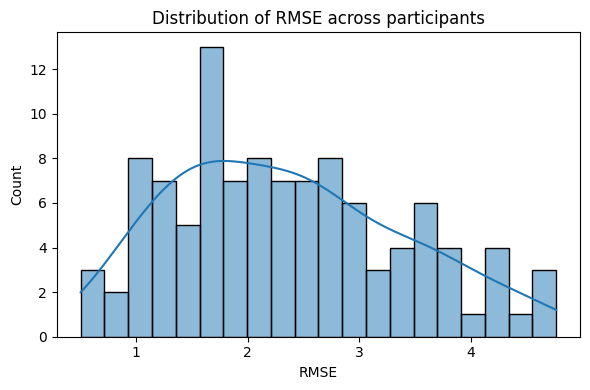

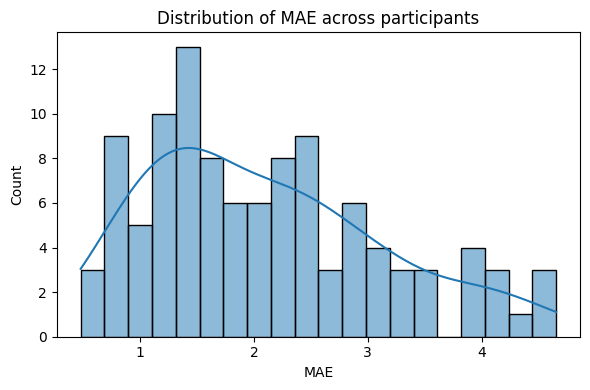

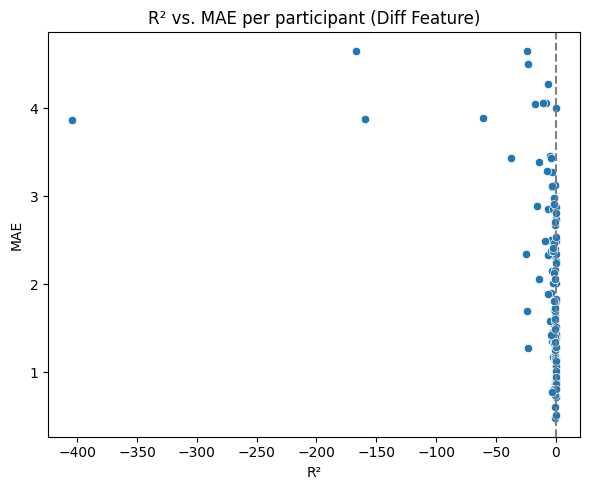

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# R² by TestPID
plt.figure(figsize=(12, 5))
sns.barplot(x='TestPID', y='R2', data=rf_lopo_df)
plt.title('LOPO R² by Participant (Diff Feature)')
plt.xticks(rotation=90)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# MAE by TestPID
plt.figure(figsize=(12, 5))
sns.barplot(x='TestPID', y='MAE', data=rf_lopo_df)
plt.title('LOPO MAE by Participant (Diff Feature)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Metric distributions
metrics = ['R2', 'RMSE', 'MAE']
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(rf_lopo_df[metric], kde=True, bins=20)
    plt.title(f'Distribution of {metric} across participants')
    plt.xlabel(metric)
    plt.tight_layout()
    plt.show()

# R² vs. MAE
plt.figure(figsize=(6, 5))
sns.scatterplot(x='R2', y='MAE', data=rf_lopo_df)
plt.title('R² vs. MAE per participant (Diff Feature)')
plt.xlabel('R²')
plt.ylabel('MAE')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


### SVM